# **텐서플로우 사용방법**
- Graph 생성
- Session 사용하여 Operation(Op) 수행

---

In [1]:
%matplotlib inline
import os
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

- X: 시카고 도시에 있는 화재의 수
- Y: 시카고 도시에 있는 범죄의 수

In [3]:
path = 'dataset/regression.csv'

df= pd.read_csv(path)

df.head(5)

,X,Y
0,6.2,29
1,9.5,44
2,10.5,36
3,7.7,37
4,8.6,53


In [4]:
x = df['X'].values.reshape(-1,1).astype(np.float32)
y = df['Y'].values.reshape(-1,1).astype(np.float32)

print('x:',x[:5],'\n')
print('y:',y[:5])

x: [[ 6.2]
 [ 9.5]
 [10.5]
 [ 7.7]
 [ 8.6]] 

y: [[29.]
 [44.]
 [36.]
 [37.]
 [53.]]


In [5]:
def data_partition(x,y):
    idx = np.arange(len(x))
    np.random.shuffle(idx)

    trn_idx = idx[:int(len(x)*0.6)] # 60%
    val_idx = idx[int(len(x)*0.6):int(len(x)*0.8)] # 20%
    tst_idx = idx[int(len(x)*0.8):] # 20%
    
    return {'train': {'x': x[trn_idx], 
                      'y': y[trn_idx]},
            'valid': {'x': x[val_idx],
                     'y': y[val_idx]},
            'test': {'x': x[tst_idx],
                     'y': y[tst_idx]}
           }

In [6]:
data_dict = data_partition(x,y)
data_dict['train']['x']

array([[34.1],
       [ 9.5],
       [11.9],
       [ 4.8],
       [11. ],
       [10.5],
       [10.5],
       [15.1],
       [21.6],
       [39.7],
       [ 5.7],
       [ 2. ],
       [21.8],
       [ 9. ],
       [ 5.6],
       [ 5. ],
       [ 8.6],
       [ 7.7],
       [18.5],
       [17.4],
       [ 7.3],
       [10.7],
       [23.3],
       [ 2.2],
       [ 4. ]], dtype=float32)

In [7]:
with open('./dataset/data_dict.pkl', 'wb') as f:
    pickle.dump(data_dict, f, pickle.HIGHEST_PROTOCOL)    

$$ \text{mean squared error} = (y - \hat{y})^2$$

$$\hat{y} = Wx+b$$

---

1) **Graph 생성**


In [8]:
tf.reset_default_graph()

- graph에 흘려보내는 데이터

In [9]:
X = tf.placeholder(shape=[None, 1], dtype=tf.float32, name = 'X')
Y = tf.placeholder(shape=[None, 1], dtype=tf.float32, name = 'Y')

- graph의 학습 파라미터

In [10]:
W = tf.get_variable(name='weight', shape=[1,1], initializer=tf.zeros_initializer())
b = tf.get_variable(name='bias', shape=[1,1], initializer=tf.zeros_initializer()) # trainable
print(W)
print(b)

<tf.Variable 'weight:0' shape=(1, 1) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1, 1) dtype=float32_ref>


- 모델 생성

In [11]:
Y_predicted = tf.matmul(X,W)+b 
Y_predicted

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

- 손실함수(목적함수) 정의

In [12]:
loss = tf.reduce_mean(tf.square(Y-Y_predicted), name='MSE')
loss

<tf.Tensor 'MSE:0' shape=() dtype=float32>

- op object들을 효율적으로 관리하기 위해 그룹(collection)을 하거나 이름(name)을 만듬

In [13]:
tf.get_collection(tf.GraphKeys.LOSSES)

[]

In [14]:
tf.add_to_collection(tf.GraphKeys.LOSSES, loss)

- 아래와 같이 원하는 그래프 키에 해당되는 tensor를 불러올 수 있음

In [15]:
tf.get_collection(tf.GraphKeys.LOSSES)

[<tf.Tensor 'MSE:0' shape=() dtype=float32>]

- 아래와 같이 원하는 그래프 키와 이름과 함께 검색하여 tensor를 불러올 수 있음

In [16]:
tf.get_collection(tf.GraphKeys.LOSSES, 'MSE')

[<tf.Tensor 'MSE:0' shape=() dtype=float32>]

In [17]:
tf.add_to_collection('placeholders', X)
tf.add_to_collection('placeholders', Y)
tf.add_to_collection('pred', Y_predicted)

In [18]:
tf.get_collection('placeholders')

[<tf.Tensor 'X:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Y:0' shape=(?, 1) dtype=float32>]

- 최적화

In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

train_op = optimizer.minimize(loss)

- **tf.train.saver**
    - graph를 저장하는 것이 아니라, session(model parameter)을 저장
    - save: session을 저장(write)
    - restore: 저장된 session(parameters)를 블러옴(read) 

In [20]:
saver = tf.train.Saver()

---

2) **Session 사용하여 Operation(Op) 수행**
    - Train/Development(Validation)
    - Test

2-1) **Train/Development(Validation)**

In [21]:
batch_size =4

trn_batch_num = math.ceil(len(data_dict['train']['x'])/batch_size)
val_batch_num = math.ceil(len(data_dict['valid']['x'])/batch_size)
tst_batch_num = math.ceil(len(data_dict['test']['x'])/batch_size)

In [22]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

sess =tf.Session(config=config)
sess.run(tf.global_variables_initializer())

init_MSE = np.inf
stop_iter = 50
stop_counter = 0

train_cumulative_loss = []    
valid_cumulative_loss = []

for i in range(5000):

    # training
    train_batch_loss = []
    for m in range(trn_batch_num):
        start = m*batch_size
        end = m*batch_size+batch_size
        x_batch = data_dict['train']['x'][start:end]
        y_batch = data_dict['train']['y'][start:end]
        _, _loss = sess.run([train_op, loss], feed_dict={X: x_batch, Y: y_batch})
        train_batch_loss.append(_loss)

    # development
    valid_batch_loss = []
    for m in range(val_batch_num):
        start = m*batch_size
        end = m*batch_size+batch_size
        x_batch = data_dict['valid']['x'][start:end]
        y_batch = data_dict['valid']['y'][start:end]
        _loss = sess.run(loss, feed_dict={X: x_batch, Y: y_batch})
        valid_batch_loss.append(_loss)

    train_cumulative_loss.append(np.mean(train_batch_loss))
    valid_cumulative_loss.append(np.mean(valid_batch_loss))
    
    stop_counter += 1   
    
    if i % 10 == 0:
        if np.mean(valid_batch_loss) < init_MSE:
            init_MSE = np.mean(valid_batch_loss)
            saver.save(sess, './checkpoints/linear-model',global_step=i)
            print('epoch {}:'.format(str(i).zfill(3)), 
                  'trn_loss({})'.format(np.mean(train_batch_loss)), 
                  'val_loss({})'.format(np.mean(valid_batch_loss)))
            stop_counter = 0
            
    # early stopping        
    if stop_counter >= stop_iter:
        break

epoch 000: trn_loss(1943.4554443359375) val_loss(658.5226440429688)
epoch 010: trn_loss(1387.1087646484375) val_loss(370.4718933105469)
epoch 020: trn_loss(1007.6307373046875) val_loss(229.87185668945312)
epoch 030: trn_loss(763.7022094726562) val_loss(191.35438537597656)


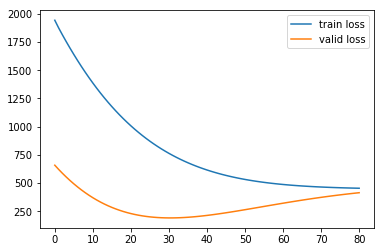

In [23]:
plt.plot(train_cumulative_loss, label = 'train loss')
plt.plot(valid_cumulative_loss, label = 'valid loss')
plt.legend()

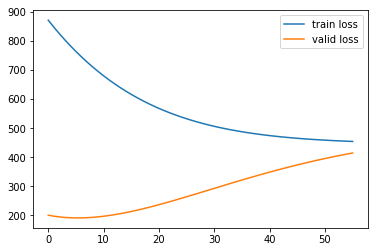

In [24]:
plt.plot(train_cumulative_loss[25:125], label = 'train loss')
plt.plot(valid_cumulative_loss[25:125], label = 'valid loss')
plt.legend()

$$\hat{y} = Wx+b$$

In [25]:
sess.run(W)

array([[2.2565587]], dtype=float32)

In [26]:
sess.run(b)

array([[3.3299823]], dtype=float32)

In [27]:
sess.close()